In [71]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [72]:
elev = pd.read_csv("measures_elev.csv", index_col=0)
area = pd.read_csv("measures_area.csv", index_col=0)
grid = pd.read_csv("measures_grid.csv", index_col=0)
frac = pd.read_csv("measures_frac.csv", index_col=0)
dens = pd.read_csv("measures_dens.csv").drop(['system:index', '.geo'], axis=1)
indx = pd.read_csv("measures_indx.csv").drop(['system:index', '.geo'], axis=1)

In [73]:
measures = elev.merge(area, left_on='city', right_on='city', how='inner')

for i in [grid, frac, dens, indx]:
    measures = measures.merge(i, left_on='city', right_on='city', how='inner')

measures.head()

city  gradient_iqr  gradient_max  gradient_min  elevation_iqr  \
0  New York City        0.0220         0.261           0.0          5.549   
1    Los Angeles        0.0220         0.861           0.0         14.297   
2        Chicago        0.0200         0.632           0.0          2.231   
3        Houston        0.0090         0.450           0.0          2.024   
4        Phoenix        0.0035         0.031           0.0          2.092   

   elevation_max  elevation_min   area_min       area_max     area_mean  ...  \
0         17.362         -2.172   0.000000   29805.231165    940.735693  ...   
1        125.212         77.119   0.000000   55099.213429   2074.662064  ...   
2        193.627        175.077   0.000000   67792.071598   2694.566730  ...   
3         16.875         -0.121   0.000000   87922.170451   1442.117795  ...   
4        318.511        310.681  96.625412  208608.366002  24355.289146  ...   

   fractal_streets  fractal_buildings     day_mean   day_stdDev  night_mean  \
0         1.675910           1.623507   766.850760  1305.399601  151.310293   
1         1.657529           1.578059   383.010164   900.355617   45.812781   
2         1.650953           1.561960  1064.810165  1338.282236   57.818916   
3         1.645951           1.514563   323.573247   609.189522   18.264499   
4         1.409317           1.184342    15.587955    37.057716    4.651462   

   night_stdDev  ndvi_mean  ndvi_stdDev  ndwi_mean  ndwi_stdDev  
0    213.293338   0.188684     0.184467   0.326142     0.172623  
1    103.845602   0.151579     0.143746   0.144419     0.100925  
2    221.753870   0.155867     0.152960   0.538388     0.072540  
3     53.723820   0.307336     0.188677   0.234601     0.093729  
4     14.016248   0.222122     0.201458   0.175803     0.119662  

[5 rows x 33 columns]

In [74]:
matrix = measures.drop(['city', 'gradient_min', 'gradient_max', 
                        'ndvi_stdDev', 'ndwi_stdDev', 
                        'elevation_min', 'elevation_max', 
                        'area_min', 'area_max'], axis=1).corr().reset_index().melt(id_vars='index', 
                                                                                   var_name='variable', 
                                                                                   value_name='value')

In [75]:
import hvplot.pandas
import hvplot

In [76]:
# Make the heatmap with hvplot
heatmap = matrix.hvplot.heatmap(
    x="index",
    y="variable",
    C="value", 
    reduce_function=np.mean,
    frame_height=600,
    frame_width=600,
    flip_yaxis=True,
    rot=90,
    colorbar=False,
    cmap="bmw",
    xlabel="",
    ylabel="",
)

heatmap = heatmap.redim(index="reference", variable="comparison")
heatmap = heatmap.opts(toolbar=None, colorbar=True, clim=(-1, 1))

In [77]:
heatmap

:HeatMap   [reference,comparison]   (value)

In [577]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [488]:
indexes = pd.DataFrame(measures.city)

In [489]:
indexing = measures[['orientation_entropy', 'circuity_avg', 'prop_4way', 'prop_deadend']]

scaler = MinMaxScaler(feature_range=(0.1, 1))
scaled = scaler.fit_transform(indexing)
scaled = pd.DataFrame(scaled)

In [490]:
from scipy import stats

indexes['griddedness'] = stats.gmean(scaled, axis=1)

In [491]:
indexes['fractalness'] = measures[['fractal_streets', 'fractal_buildings']].mean(axis=1)
indexes['peopledness'] = np.log(measures['day_mean'])
indexes['environment'] = measures[['ndwi_mean', 'ndvi_mean']].mean(axis=1)

indexing = measures[['length_mean', 'area_mean']]

scaled = scaler.fit_transform(indexing)
scaled = pd.DataFrame(scaled)

indexes['length'] = scaled.mean(axis=1)
indexes['grades'] = measures['gradient_iqr']

In [492]:
print(indexes.shape)
indexes = indexes.dropna()
print(indexes.shape)

(304, 7)
(303, 7)


In [493]:
indexes.head()

city  griddedness  fractalness  peopledness  environment  \
0  New York City     0.426645     1.649708     6.642292     0.257413   
1    Los Angeles     0.505704     1.617794     5.948062     0.147999   
2        Chicago     0.412003     1.606456     6.970552     0.347128   
3        Houston     0.426131     1.580257     5.779426     0.270969   
4        Phoenix     0.392418     1.296829     2.746498     0.198962   

     length  grades  
0  0.184044  0.0220  
1  0.260590  0.0220  
2  0.218238  0.0200  
3  0.263512  0.0090  
4  0.901936  0.0035

In [862]:
scaler = StandardScaler()
scaled = scaler.fit_transform(indexes.drop('city', axis=1))

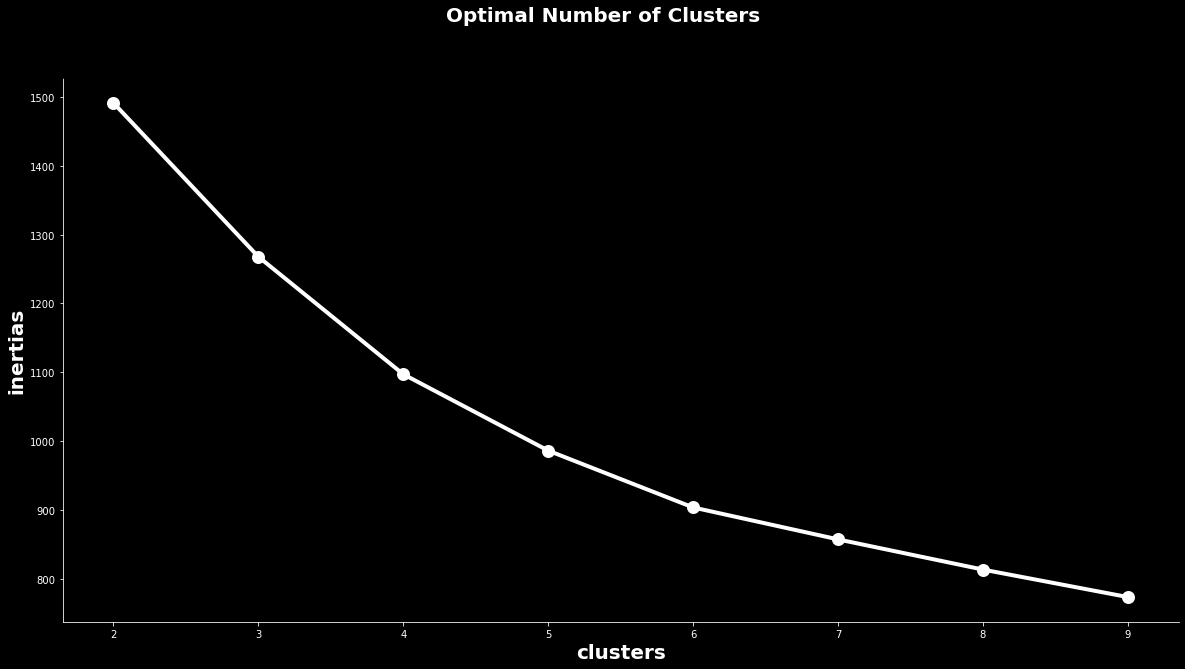

In [879]:
n_clusters = list(range(2, 10))

inertias = []

for k in n_clusters:
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled)
    
    inertias.append(kmeans.inertia_)

import matplotlib as mpl
mpl.rcParams.update({'text.color':"white",
                     'axes.labelcolor':"white"})    

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')    

ax.plot(n_clusters, inertias, marker='o', ms=10, mfc='w', c='w', lw=4, mew=3)

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")


font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("clusters", color="w", fontdict=font)
ax.set_ylabel("inertias", color="w", fontdict=font)

fig.suptitle('Optimal Number of Clusters', color='w', size=20, weight='bold')
fig.savefig('scree-plot.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

There is no real elbow here, the curve starts to bend somewhere between 5 and 6; so we will settle on 6.

In [881]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled)
           
indexes['label'] = kmeans.labels_

In [882]:
cities = pd.read_csv("cities.csv", index_col=0)
cities.head()

city       state        lat         lon
0  New York City    New York  40.713524  -74.006710
1    Los Angeles  California  34.053714 -118.242653
2        Chicago    Illinois  41.883823  -87.632078
3        Houston       Texas  29.760159  -95.369418
4        Phoenix     Arizona  33.439971 -112.204870

In [883]:
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lon, cities.lat), crs=4326)

In [884]:
cities = cities[(cities['state']!="Alaska") & (cities['state']!="Hawaii")]

In [885]:
combined = indexes.merge(cities, left_on='city', right_on='city', how='inner')

In [886]:
states = gpd.read_file(f"https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")

off_limits = [
    '72',
    '78',
    '60',
    '66',
    '69',
    '15',
    '02'
]

states = states[~states.GEOID.isin(off_limits)].to_crs(4326)

In [887]:
import xarray as xr
import cartopy.crs as ccrs

import hvplot.pandas
import hvplot.xarray

from colorcet import palette

In [888]:
pointmap = states.hvplot(geo=True, projection=ccrs.LambertConformal(), 
                         color='#000000', line_color='#ffffff', alpha=0.5, width=800, height=600) 

pointmap = pointmap * combined.hvplot.points('lon', 'lat', geo=True, projection=ccrs.LambertConformal(), 
                                             color='label', cmap=palette['bmw'], colorbar=False,
                                             hover_cols=['city', 'state', 'label'])

pointmap = pointmap.opts(toolbar=None, active_tools=['box_zoom', 'wheel_zoom'])

pointmap

:Overlay
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Points.I   :Points   [lon,lat]   (label,city,state)

In [404]:
bivariate = measures.hvplot.bivariate('fractal_buildings', 
                                      'fractal_streets',
                                      cmap='bmw', legend=False, width=800, height=600)

bivariate = bivariate.redim(fractal_streets="Streets", fractal_buildings="Buildings")
bivariate = bivariate.opts(toolbar=None, colorbar=True)

bivariate = bivariate * measures.hvplot.scatter('fractal_buildings', 
                                                'fractal_streets', 
                                                hover_cols=['city'],
                                                color='black', legend=False)

bivariate

:Overlay
   .Bivariate.I :Bivariate   [Buildings,Streets]   (Density)
   .Scatter.I   :Scatter   [fractal_buildings]   (fractal_streets,city)

In [222]:
table = measures.hvplot.table(['city', 'fractal_buildings', 'fractal_streets', 'day_mean', 'night_mean'], 
                              width=800, height=350)
table

:Table   [city,fractal_buildings,fractal_streets,day_mean,night_mean]

In [598]:
from sklearn.neighbors import NearestNeighbors

indexes_ri = indexes.reset_index().head(100)
indexes_np = np.array(indexes_ri.drop(['city', 'label', 'index'], axis=1))

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(indexes_np)
distances, indices = nbrs.kneighbors(indexes_np, n_neighbors = 4)

In [599]:
comparison = {}

for result in indices:
    closest = []
    
    for player in result[1:4]:
        closest.append(indexes.iloc[player, 0])
    comparison[indexes.iloc[result[0], 0]] = closest

In [600]:
comparison_df = pd.DataFrame.from_dict(comparison, orient='index', 
                                       columns=['first', 'second', 'third'])

comparison_df.head()

first        second       third
New York City        Chicago  Philadelphia      Boston
Los Angeles          Houston       Seattle      Boston
Chicago        New York City  Philadelphia      Boston
Houston              Seattle   Los Angeles      Boston
Phoenix            Henderson       Gilbert  Greensboro

In [601]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(indexes_np)
distances, indices = nbrs.kneighbors(indexes_np, n_neighbors = indexes_ri.shape[0])

In [602]:
complete_list = []

for i in np.arange(0, indices.shape[0]):
    data = pd.DataFrame({'city': indexes_ri.city[i],
                         'index': indices[i],
                         'distance': distances[i]})
    
    complete_list.append(data)

In [603]:
complete_df = pd.concat(complete_list, ignore_index=False)
complete_df = complete_df.merge(pd.DataFrame(indexes_ri.city).reset_index(), 
                                left_on='index', 
                                right_on='index',
                                how='left')

In [604]:
complete_df.head()

city_x  index  distance         city_y
0  New York City      0  0.000000  New York City
1  New York City      2  0.345053        Chicago
2  New York City      5  0.424551   Philadelphia
3  New York City     20  0.684618         Boston
4  New York City      1  0.712078    Los Angeles

In [772]:
ranks = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
ranks = ranks[4]

ranks = pd.DataFrame({'city': ranks['City'].str.replace('\[.*\]', ''),
                      'rank': ranks['2019rank']})

In [606]:
ranked_df = complete_df.merge(ranks.rename(columns={'rank': 'rank_x'}), 
                              left_on='city_x', 
                              right_on='city', 
                              how='left').drop('city', axis=1)

ranked_df = ranked_df.merge(ranks.rename(columns={'rank': 'rank_y'}), 
                            left_on='city_y', 
                            right_on='city', how='left').drop('city', axis=1)

In [607]:
ranked_df = ranked_df.sort_values(['rank_x', 'rank_y'])

In [608]:
# Make the heatmap with hvplot
heatmap = ranked_df.hvplot.heatmap(
    x="city_x",
    y="city_y",
    C="distance", 
    reduce_function=np.mean,
    frame_height=600,
    frame_width=600,
    flip_yaxis=True,
    rot=90,
    colorbar=False,
    cmap="bmw",
    xlabel="",
    ylabel="",
)

heatmap = heatmap.redim(city_x="reference", city_y="comparison")
heatmap = heatmap.opts(toolbar=None, active_tools=['box_zoom', 'wheel_zoom'], colorbar=True, clim=(0, 1))

In [612]:
heatmap

:HeatMap   [reference,comparison]   (distance)

In [611]:
hvplot.save(heatmap, 'heatmap.html')

In [664]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(distances)

In [668]:
similarity_score = 1 - scaled

In [669]:
complete_list = []

for i in np.arange(0, indices.shape[0]):
    data = pd.DataFrame({'city': indexes_ri.city[i],
                         'index': indices[i],
                         'similarity': similarity_score[i]})
    
    complete_list.append(data)

In [671]:
complete_df = pd.concat(complete_list, ignore_index=False)
complete_df = complete_df.merge(pd.DataFrame(indexes_ri.city).reset_index(), 
                                left_on='index', 
                                right_on='index',
                                how='left')

In [672]:
complete_df.head()

city_x  index  similarity         city_y
0  New York City      0    1.000000  New York City
1  New York City      2    0.463379        Chicago
2  New York City      5    0.481381   Philadelphia
3  New York City     20    0.350092         Boston
4  New York City      1    0.352244    Los Angeles

In [673]:
ranked_df = complete_df.merge(ranks.rename(columns={'rank': 'rank_x'}), 
                              left_on='city_x', 
                              right_on='city', 
                              how='left').drop('city', axis=1)

ranked_df = ranked_df.merge(ranks.rename(columns={'rank': 'rank_y'}), 
                            left_on='city_y', 
                            right_on='city', how='left').drop('city', axis=1)

In [674]:
ranked_df = ranked_df.sort_values(['rank_x', 'rank_y'])

In [677]:
# Make the heatmap with hvplot
heatmap = ranked_df.hvplot.heatmap(
    x="city_x",
    y="city_y",
    C="similarity", 
    reduce_function=np.mean,
    frame_height=600,
    frame_width=600,
    flip_yaxis=True,
    rot=90,
    colorbar=False,
    cmap="bmw",
    xlabel="",
    ylabel="",
)

heatmap = heatmap.redim(city_x="reference", city_y="comparison")
heatmap = heatmap.opts(toolbar=None, active_tools=['box_zoom', 'wheel_zoom'], colorbar=True, clim=(0, 1))

In [679]:
heatmap

:HeatMap   [reference,comparison]   (similarity)

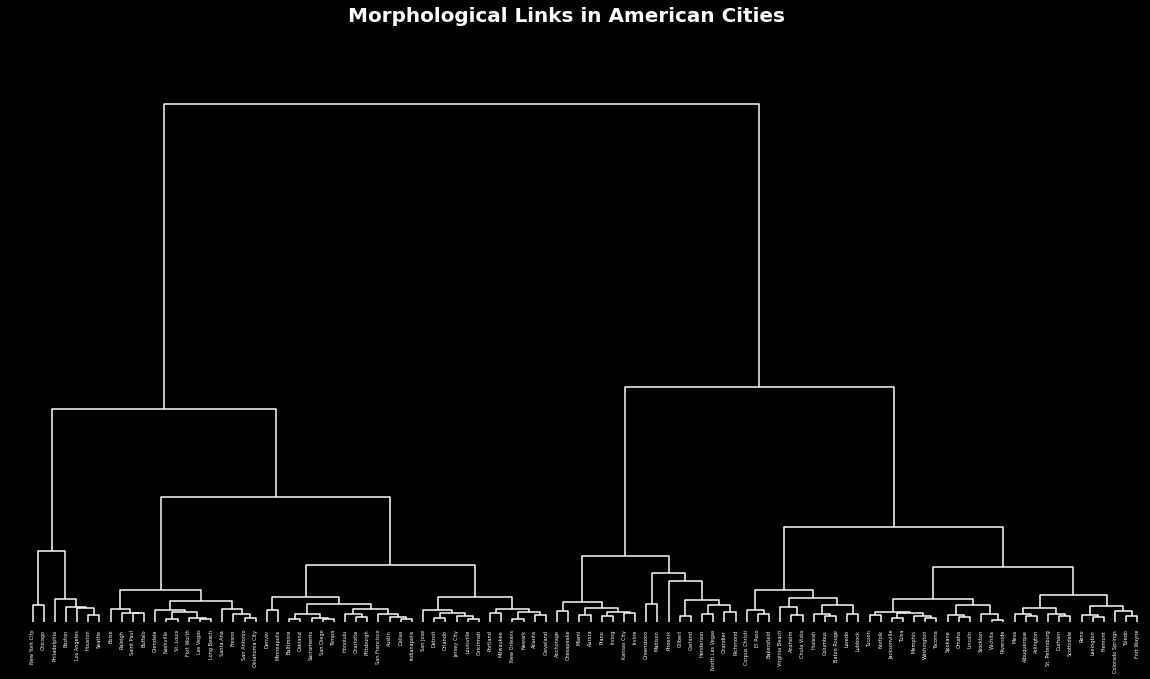

In [860]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(indexes_np, 'ward')

label_list = np.array(indexes.head(100).city)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')

dendrogram(linked,
           ax=ax,
           orientation='top',
           labels=label_list, 
           color_threshold=0,
           above_threshold_color='w',
           distance_sort='descending',
           show_leaf_counts=True)

labels = ax.get_xmajorticklabels()

for label in labels:
    label.set_color('w')

ax.set_facecolor('k')
    
fig.suptitle('Morphological Links in American Cities', color='w', size=20, weight='bold')
fig.savefig('morphology-dendrogram.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

In [728]:
edges = comparison_df.rename(columns={'first': '1', 
                                      'second': '2',
                                      'third': '3'}).reset_index().melt(id_vars='index', 
                                                                        var_name='standing', 
                                                                        value_name='target')

edges['standing'] = edges['standing'].astype('int64')

edges.columns = ['focal', 'standing', 'target']

edges = edges[(edges['focal']!='Honolulu') & (edges['focal']!='Anchorage')]
edges = edges[(edges['target']!='Honolulu') & (edges['target']!='Anchorage')]

In [729]:
nodes = cities[cities.city.isin(edges.focal)][['city', 'lat', 'lon']].set_index('city')

In [730]:
import networkx as nx

In [800]:
info = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
info = info[4]

info = pd.DataFrame({'city': info['City'].str.replace('\[.*\]', ''),
                     'rank': info['2019rank'],
                     'population': info['2010Census'],
                     'density': info['2016 population density.1']})

In [801]:
nodes_attributes = info[info.city.isin(edges.focal)].set_index('city').to_dict()

In [802]:
G = nx.from_pandas_edgelist(edges, source='target', target='focal')

nx.set_node_attributes(G, nodes_attributes['rank'], 'rank')
nx.set_node_attributes(G, nodes_attributes['population'], 'population')
nx.set_node_attributes(G, nodes_attributes['density'], 'density')

In [806]:
network = hvnx.draw_spring(G, node_color='density', cmap='bmw', width=500, height=500)
network = network.opts(toolbar=None, active_tools=['box_zoom', 'wheel_zoom'], colorbar=True, clim=(0, 1))

In [807]:
network

:Graph   [start,end]

In [810]:
hvplot.save(network, 'network.html')

In [892]:
comparison_df.tail(4)

first   second    third
Boise        Saint Paul  Raleigh    Tulsa
Spokane           Omaha  Lincoln  Memphis
Baton Rouge    Columbus  Hialeah  Anaheim
Tacoma       Washington  Memphis  Norfolk

In [893]:
nodes = gpd.read_file("nodes_us.gpkg")
edges = gpd.read_file("edges_us.gpkg")

In [894]:
street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}

In [928]:
city_list = comparison_df.head(4).reset_index().to_numpy().flatten()

In [929]:
import osmnx as ox

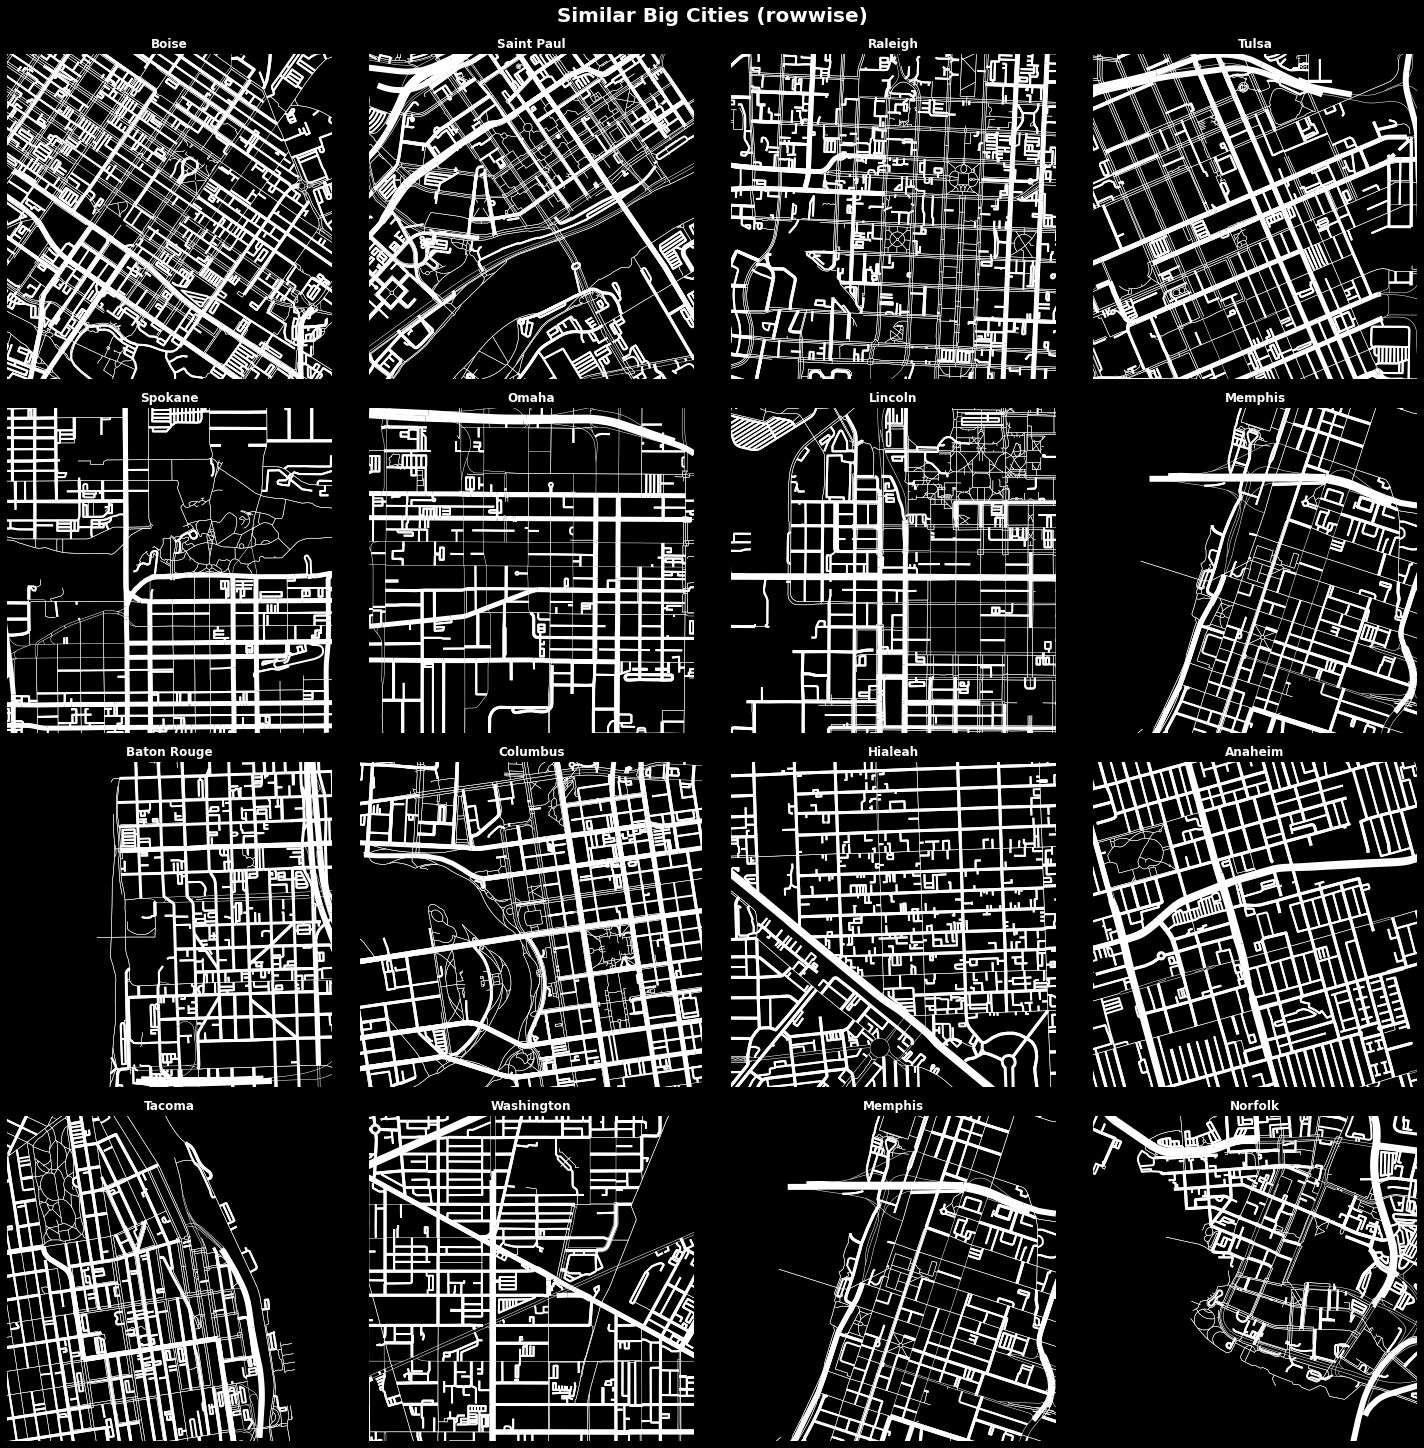

In [933]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 16):
    
    node = nodes[nodes['city']==city_list[i]]
    edge = edges[edges['city']==city_list[i]]
    
    # this code is exactly what happens inside the osmnx.plot.plot_figure_ground() function
    edge_linewidths = []
    
    default_width = 0.5
    
    for label in edge.highway:
        street_type = label[0] if isinstance(label, list) else label
    
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)
    
    #  we are just editing the function here to plot on axis i so that we can have small multiples 
    edge.plot(ax=axs[i], color='w', lw=edge_linewidths)
    
    bbox = ox.utils_geo.bbox_from_point((cities[cities['city']==city_list[i]].iloc[0]['lat'], 
                                         cities[cities['city']==city_list[i]].iloc[0]['lon']), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(cities[cities['city']==city_list[i]].iloc[0]['city'], color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Similar Big Cities (rowwise)', color='w', size=20, weight='bold')
fig.savefig('urban-similarity-top.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [938]:
city_list = comparison_df.tail(4).reset_index().to_numpy().flatten()

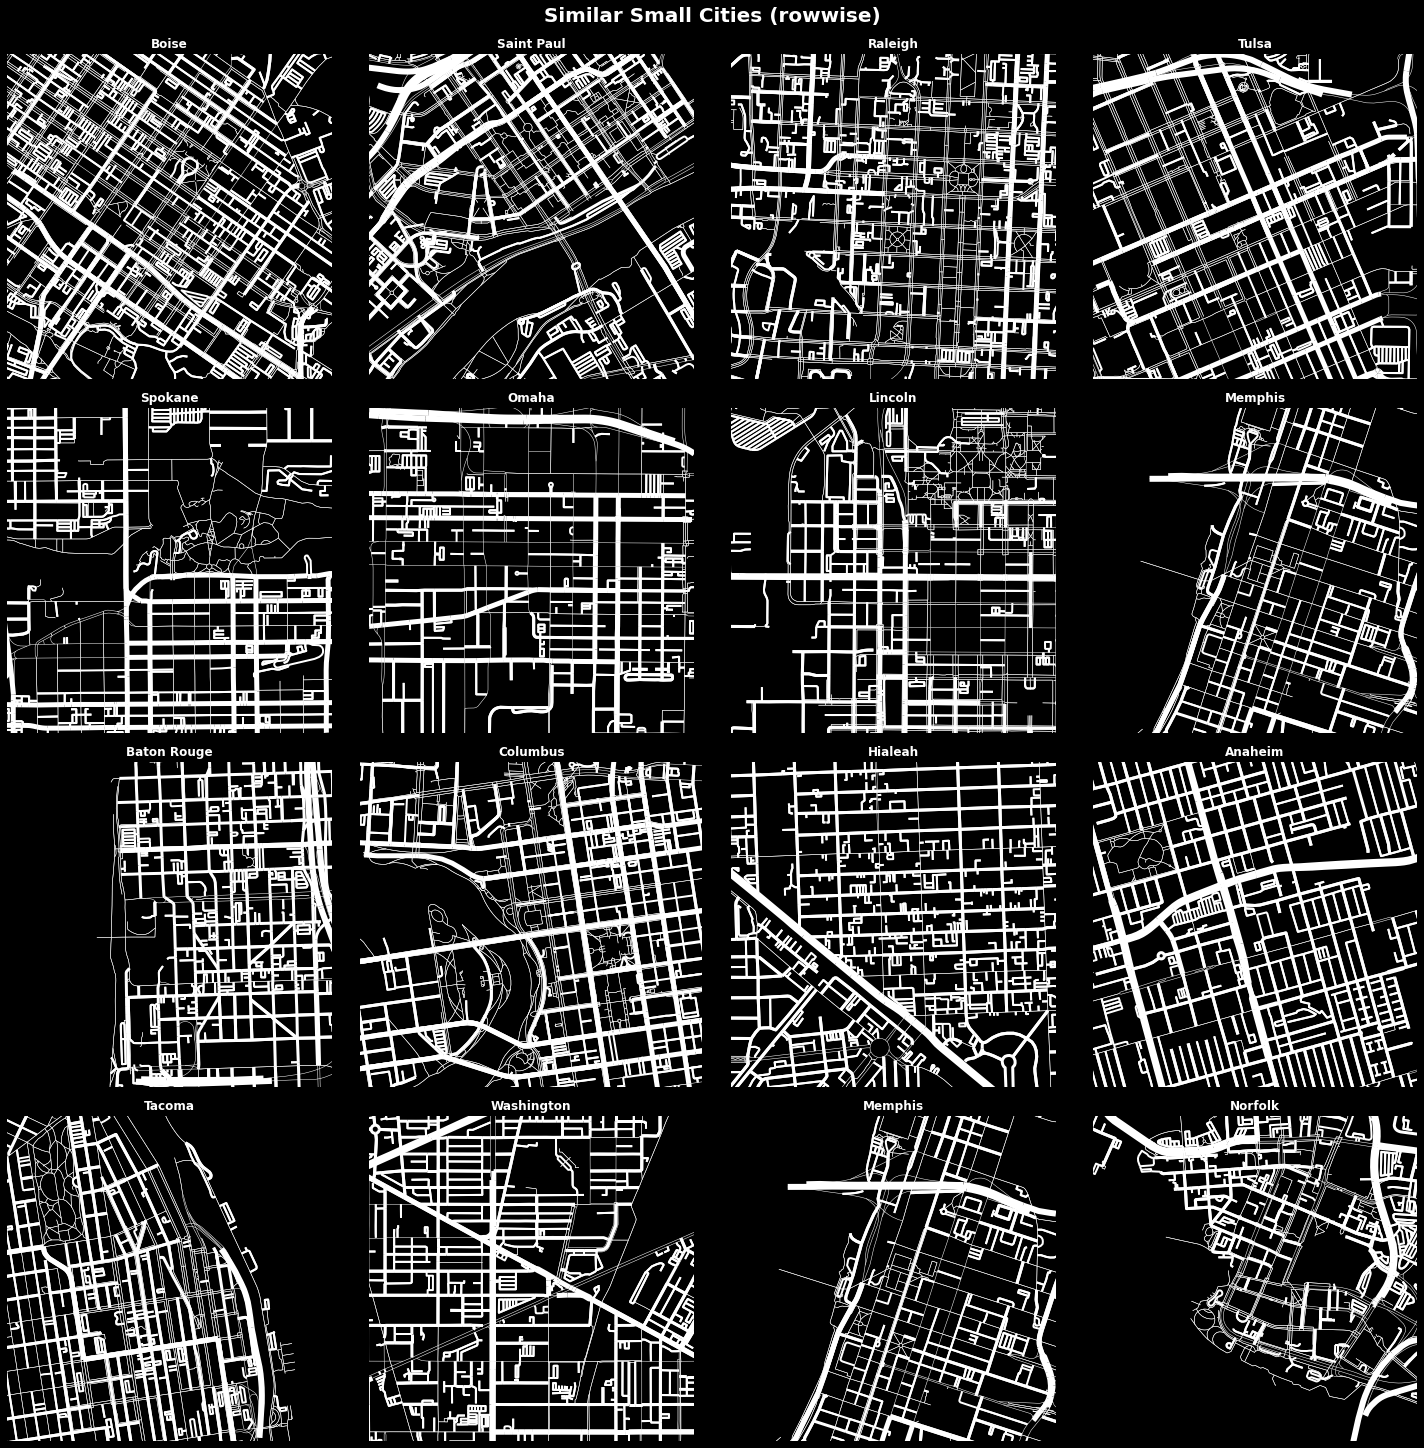

In [939]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 16):
    
    node = nodes[nodes['city']==city_list[i]]
    edge = edges[edges['city']==city_list[i]]
    
    # this code is exactly what happens inside the osmnx.plot.plot_figure_ground() function
    edge_linewidths = []
    
    default_width = 0.5
    
    for label in edge.highway:
        street_type = label[0] if isinstance(label, list) else label
    
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)
    
    #  we are just editing the function here to plot on axis i so that we can have small multiples 
    edge.plot(ax=axs[i], color='w', lw=edge_linewidths)
    
    bbox = ox.utils_geo.bbox_from_point((cities[cities['city']==city_list[i]].iloc[0]['lat'], 
                                         cities[cities['city']==city_list[i]].iloc[0]['lon']), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(cities[cities['city']==city_list[i]].iloc[0]['city'], color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Similar Small Cities (rowwise)', color='w', size=20, weight='bold')
fig.savefig('urban-similarity-bottom.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')